# Predictor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [1]:
import time
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from scipy.stats import ttest_1samp, ttest_ind
from sklearn.metrics import mean_absolute_error

from data.eluc_data import ELUCData
from data import constants
from predictors.predictor import Predictor
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor
from predictors.sklearn.sklearn_predictor import LinearRegressionPredictor, RandomForestPredictor

### Load Dataset

In [2]:
dataset = ELUCData()

### Train Models

#### Neural Network

In [9]:
nn_config = {
    "features": constants.NN_FEATS,
    "label": "ELUC",
    "hidden_sizes": [4096],
    "linear_skip": True,
    "dropout": 0,
    "device": "mps",
    "epochs": 3,
    "batch_size": 2048,
    "train_pct": 1,
    "step_lr_params": {"step_size": 1, "gamma": 0.1},
}
nnp = NeuralNetPredictor(nn_config)

In [ ]:
results = nnp.fit(dataset.train_df[nn_config["features"]], dataset.train_df[nn_config["label"]], verbose=True)
nnp.save("predictors/neural_network/trained_models/test")

In [10]:
nnp = NeuralNetPredictor.load("predictors/neural_network/trained_models/experiment_nn")
print(f"MAE Neural Net: {mean_absolute_error(dataset.test_df[nn_config['label']], nnp.predict(dataset.test_df[nn_config['features']]))}")

MAE Neural Net: 0.04711493104696274


#### Linear Regression

In [12]:
linreg_config = {
    "features": constants.DIFF_LAND_USE_COLS,
    "n_jobs": -1,
}
linreg = LinearRegressionPredictor(linreg_config)

In [ ]:
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
linreg.save("predictors/sklearn/trained_models/experiment_linreg")

In [13]:
linreg = LinearRegressionPredictor.load("predictors/sklearn/trained_models/experiment_linreg")
print(f"MAE Linear Regression: {mean_absolute_error(dataset.test_df['ELUC'], linreg.predict(dataset.test_df[constants.DIFF_LAND_USE_COLS]))}")

MAE Linear Regression: 0.07567060738801956


#### Random Forest

In [3]:
forest_config = {
    "features": constants.NN_FEATS,
    "n_jobs": -1,
    "max_features": "sqrt",
    "random_state": 42
}
forest = RandomForestPredictor(forest_config)

In [4]:
# Note: The original paper trains from 1982 onwards but this is too slow and large for the
# purpose of this example.
forest.fit(dataset.train_df.loc[2002:][constants.NN_FEATS], dataset.train_df.loc[2002:]["ELUC"])
forest.save("predictors/sklearn/trained_models/experiment_rf")

In [5]:
forest = RandomForestPredictor.load("predictors/sklearn/trained_models/experiment_rf")
print(f"MAE Random Forest: {mean_absolute_error(dataset.test_df['ELUC'], forest.predict(dataset.test_df[constants.NN_FEATS]))}")

MAE Random Forest: 0.037707034150731636


### Create Heatmaps

In [7]:
def create_heatmap(model: Predictor, sample: pd.DataFrame, features=None, scale={}, title=None, save_path=None):
    """
    Creates a 2d heatmap of the outcomes of the model on synthetic data.
    The columns correspond to current land type and the rows are the land type converted to.
    Synthetic data is created by using the non-land features of the sample and taking the cross
    join between the artificial land use change from 0 to 1 of every type.
    """
    dummy_data = []
    for i in range(len(constants.LAND_USE_COLS)):
        for j in range(len(constants.LAND_USE_COLS)):
            row = [0 for _ in range(len(constants.LAND_USE_COLS) * 2)]
            row[i] = 1.0
            if i == j:
                row[len(constants.LAND_USE_COLS) + j] = 0.0
            else:
                row[len(constants.LAND_USE_COLS) + j] = 1.0
                row[len(constants.LAND_USE_COLS) + i] = -1.0
            dummy_data.append(dict(zip(constants.LAND_USE_COLS + constants.DIFF_LAND_USE_COLS, row)))

    dummy_df = pd.DataFrame(dummy_data)

    # Gets sample of lat/lon/time/cell_area
    non_land_df = sample[constants.NONLAND_FEATURES]
    nn_input_df = dummy_df.merge(non_land_df, how="cross")
    if features:
        nn_input_df = nn_input_df[features]
    preds = model.predict(nn_input_df)
    # Aggregate samples. Since pandas merge maintains left key order, we can just sum each group of len(samples)
    # Thanks, ChatGPT!
    chunks = np.split(preds, len(preds) // len(sample))
    sums = np.sum(chunks, axis=1)
    preds = sums / len(sample)

    # Rearrange the heatmap data into 2D shape
    heatmap_data = np.zeros((len(constants.LAND_USE_COLS), len(constants.LAND_USE_COLS)))
    for i in range(len(preds)):
        heatmap_data[i // len(constants.LAND_USE_COLS), i % len(constants.LAND_USE_COLS)] = preds[i]
    
    # Hide the ability to move land to primf/primn
    idxs = [constants.LAND_USE_COLS.index(col) for col in constants.RECO_COLS]
    non_idxs = [constants.LAND_USE_COLS.index(col) for col in constants.LAND_USE_COLS if (col not in constants.RECO_COLS)]
    heatmap_data = heatmap_data[idxs + non_idxs,:]
    heatmap_data = heatmap_data[:, idxs]

    # Draw heatmap
    colors = ["darkgreen", "white", "red"]
    bins = 1000
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=bins)
    sorted_labels = np.array(constants.LAND_USE_COLS)[idxs + non_idxs]
    ax = sns.heatmap(heatmap_data, center=0, cmap=cmap, xticklabels=constants.RECO_COLS, yticklabels=sorted_labels, **scale)
    ax.invert_yaxis()
    plt.xlabel("To")
    plt.ylabel("From")
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

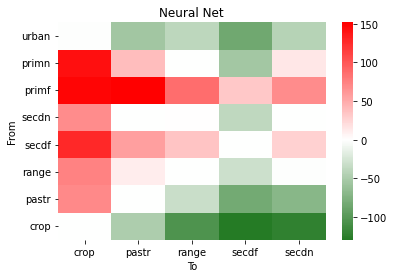

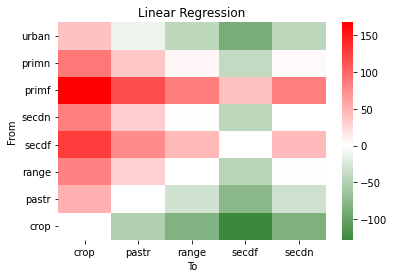

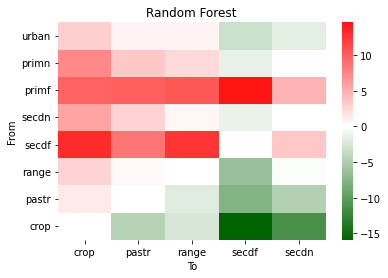

In [14]:
sample = dataset.test_df.sample(frac=0.01, random_state=100)
create_heatmap(nnp, sample, title="Neural Net")
create_heatmap(linreg, sample, title="Linear Regression")
create_heatmap(forest, sample, title="Random Forest")

### Statistical Significance
The models were tested by training them multiple times and comparing the samples using a t-test.

In [ ]:
def train_and_test(n, model_constructor, config, train_df, test_df, save_path, override_start_year=None):
    """
    Trains a model n times on each region and evaluates each model on each region.
    :param n: Number of times to train each model on each region.
    :param model_constructor: A function that returns a model.
    :param config: A dictionary of configuration parameters for each model type.
    :param train_df: The training data.
    :param test_df: The testing data.
    :param save_path: The path to save the results.
    :param override_start_year: If not None, overrides the start year of the test data on the ALL region.
        (This is currently only used for the random forest)
    """
    save_dir = Path(save_path).parent
    save_dir.mkdir(parents=True, exist_ok=True)
    if not Path(save_path).exists():
        with open(save_path, "w") as f:
            f.write("region,eval,mae,time\n")
    with open(save_path, "a") as f:
        # Iterate over all regions
        for train_region in constants.COUNTRY_DICT.keys():
            print(train_region)
            if train_region != "ALL":
                countries = constants.COUNTRY_DICT[train_region]
                idx = constants.COUNTRIES_DF[constants.COUNTRIES_DF["abbrevs"].isin(countries)].index.values
                train_region_df = train_df[train_df["country"].isin(idx)]
            else:
                train_region_df = train_df
            
            # n times for each region
            for i in tqdm(range(n)):
                model = model_constructor(**config)
                s = time.time()
                _ = model.fit(train_region_df, **config)
                e = time.time()
                # Evaluate on each region
                for test_region in constants.COUNTRY_DICT.keys():
                    if test_region != "ALL":
                        countries = constants.COUNTRY_DICT[test_region]
                        idx = constants.COUNTRIES_DF[constants.COUNTRIES_DF["abbrevs"].isin(countries)].index.values
                        test_region_df = test_df[test_df["country"].isin(idx)]
                    else:
                        test_region_df = test_df
                        if override_start_year:
                            test_region_df = test_region_df.loc[override_start_year:]
                    
                    mae = mean_absolute_error(model.predict(test_region_df), test_region_df["ELUC"])
                    f.write(f"{train_region},{test_region},{mae},{e - s}\n")

Generate results:

In [ ]:
model_constructors = [NeuralNetPredictor, LinearRegressionPredictor, RandomForestPredictor]
configs = [nn_config, linreg_config, forest_config]
model_names = ["neural_network", "linear_regression", "random_forest"]
for model_constructor, config, model_name in zip(model_constructors, configs, model_names):
    override_start_year = None
    if model_name == "random_forest":
        override_start_year = 2002
    train_and_test(30, model_constructor, config, dataset.train_df, dataset.test_df, f"experiments/predictor_significance/{model_name}_eval.csv", override_start_year=override_start_year)

#### Load Results and Perform T-Test

In [15]:
linreg_results = pd.read_csv("experiments/predictor/significance/linear_regression_eval.csv")
nn_results = pd.read_csv("experiments/predictor/significance/neural_network_eval.csv")
forest_results = pd.read_csv("experiments/predictor_significance/random_forest_eval.csv")

In [18]:
for region in constants.COUNTRY_DICT.keys():
    lr_region_results = linreg_results[(linreg_results["region"] == region) & (linreg_results["eval"] == region)] 
    region_results = forest_results[(forest_results["region"] == region) & (forest_results["eval"] == region)]
    other_results = nn_results[(nn_results["region"] == region) & (nn_results["eval"] == region)]
    print(f"{region} p-value forest < nn: {ttest_ind(region_results['mae'], other_results['mae'], alternative='less').pvalue}")

EU p-value forest < nn: 1.0
SA p-value forest < nn: 4.081372920256761e-96
US p-value forest < nn: 8.865504240014044e-41
ALL p-value forest < nn: 5.399007032681815e-49


#### Create Table for Latex Paper
Creates a significance table comparing the different models trained on each region and then evaluated on each region.

In [19]:
def table_results(self_name, self_results, other_results, linreg_results):
    """
    Generates results table for the overleaf paper.
    Takes in one model's results and comparison model's results as well as linreg results.
    Checks if self model is better than linreg and if self model is better than other model.
    Prints by region.
    """
    for region in constants.COUNTRY_DICT.keys():
        region_results = self_results[self_results["region"] == region]
        row = f"{self_name} ({region if region != 'ALL' else 'Global'}) & {region_results['time'].mean():.4f}"

        for eval_region in constants.COUNTRY_DICT.keys():
            # Other model significance test
            region_maes = region_results[region_results['eval'] == eval_region]['mae']
            other_maes = other_results[(other_results["region"] == region) & (other_results["eval"] == eval_region)]["mae"]
            other_pval = ttest_ind(region_maes, other_maes, alternative="less").pvalue

            # Linreg significance test
            linreg_mae = linreg_results[(linreg_results["region"] == region) & (linreg_results["eval"] == eval_region)].iloc[0]["mae"]
            linreg_pval = ttest_1samp(region_maes, linreg_mae, alternative="less").pvalue

            # Best method bolding
            bold = False
            if region == eval_region and region_maes.mean() < other_maes.mean():
                bold = True

            row += f" & ${region_maes.mean():.4f}" if not bold else f" & $\\textbf{{{region_maes.mean():.4f}}}"
            if linreg_pval <= 0.01 or other_pval <= 0.01:
                row += "^{"
                if linreg_pval <= 0.01:
                    row += "*"
                if other_pval <= 0.01:
                    row += "\\dag"
                row += "}"
            row += "$"
        row += "\\\\"
        print(row)
    print("\\hline")

def generate_table(linreg_results, forest_results, nn_results):
    """
    Prints LinReg results, then generates table for RF compared to LinReg and NN, then generates table for
    NN compared to LinReg and RF.
    """
    # Linreg
    for region in constants.COUNTRY_DICT.keys():
        region_results = linreg_results[linreg_results["region"] == region]
        row = f"LinReg ({region if region != 'ALL' else 'Global'}) & {region_results.iloc[0]['time']:.4f}"
        for eval_region in constants.COUNTRY_DICT.keys():
            row += f" & {region_results[region_results['eval'] == eval_region].iloc[0]['mae']:.4f}"
        row += "\\\\"
        print(row)
    print("\\hline")
    # Forest
    table_results("RF", forest_results, nn_results, linreg_results)

    # NN
    table_results("NeuralNet", nn_results, forest_results, linreg_results)

In [20]:
generate_table(linreg_results, forest_results, nn_results)

LinReg (EU) & 0.0847 & 0.0333 & 0.1712 & 0.1689 & 0.2061\\
LinReg (SA) & 0.5705 & 0.1360 & 0.1534 & 0.0623 & 0.1109\\
LinReg (US) & 0.3427 & 0.1399 & 0.1456 & 0.0351 & 0.0726\\
LinReg (Global) & 6.8722 & 0.1376 & 0.1503 & 0.0361 & 0.0742\\
\hline
RF (EU) & 16.4930 & $0.0517$ & $0.2078^{\dag}$ & $0.1532^{*\dag}$ & $0.2196^{\dag}$\\
RF (SA) & 206.4513 & $0.1333^{\dag}$ & $\textbf{0.0634}^{*\dag}$ & $0.0757^{\dag}$ & $0.1268^{\dag}$\\
RF (US) & 101.7903 & $0.1424$ & $0.1844^{\dag}$ & $\textbf{0.0194}^{*\dag}$ & $0.0922^{\dag}$\\
RF (Global) & 422.2839 & $0.0348^{*\dag}$ & $0.0669^{*\dag}$ & $0.0202^{*\dag}$ & $\textbf{0.0398}^{*\dag}$\\
\hline
NeuralNet (EU) & 10.6497 & $\textbf{0.0243}^{*\dag}$ & $0.2663$ & $0.2817$ & $0.3329$\\
NeuralNet (SA) & 96.4302 & $0.2516$ & $0.0991^{*}$ & $0.5507$ & $0.4120$\\
NeuralNet (US) & 71.9760 & $0.1275^{*\dag}$ & $0.2322$ & $0.0237^{*}$ & $0.1470$\\
NeuralNet (Global) & 1047.7100 & $0.0455^{*}$ & $0.1086^{*}$ & $0.0249^{*}$ & $0.0477^{*}$\\
\hline
